In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install scanpy numpy pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 107.8 MB/s eta 0:00:00


In [20]:
!pip install shap

Using device: cuda
Loading: /content/drive/MyDrive/Intro Genome Final project/DATA/donor_concat_3class_HVG2000_each_with_ADbinary.h5ad
Loaded: AnnData object with n_obs × n_vars = 89 × 6000
    obs: 'n_cells_in_class', 'Sex', 'Age at Death', 'Organism', 'Overall AD neuropathological Change', 'Class', 'n_cells_GABA', 'n_cells_GLU', 'n_cells_NONNEUR', 'AD_binary', 'AD_label'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'gene', 'celltype_tag'

Label distribution (1=Not AD, 0=AD):
disease_label_name
AD        75
Not AD    14
Name: count, dtype: int64

Data shape: (89, 6000)

Split sizes: (53, 6000) (18, 6000) (18, 6000)
Train label counts: {0: 45, 1: 8}
Val   label counts: {0: 15, 1: 3}
Test  label counts: {0: 15, 1: 3}
Saved scaler: /content/drive/MyDrive/Intro Genome Final project/scaler_threshold_tuned.joblib
Using NO pos_weight (recommended to avoid collapse).

Model:
 MLP(
  (net): Sequential(
    (0): Linear(in_features=6000, out_feature

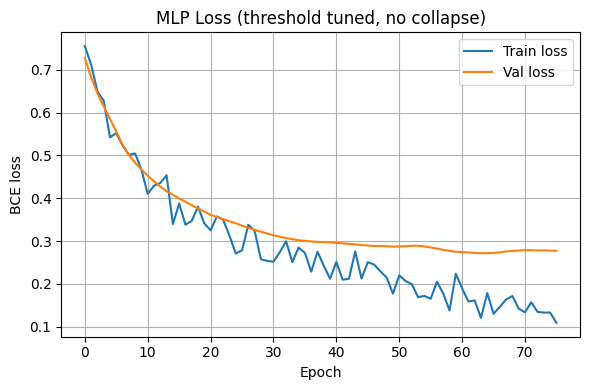


Done ✅


In [14]:
#!/usr/bin/env python3
import os
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.sparse import issparse

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    log_loss,
    balanced_accuracy_score,
    average_precision_score,
)

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


# =============================================================================
# CONFIG
# =============================================================================
H5AD_IN = "/content/drive/MyDrive/Intro Genome Final project/DATA/donor_concat_3class_HVG2000_each_with_ADbinary.h5ad"
OUT_DIR = "/content/drive/MyDrive/Intro Genome Final project"
os.makedirs(OUT_DIR, exist_ok=True)

LABEL_COL = "Overall AD neuropathological Change"
SEX_TO_KEEP = None  # "Male" / "Female" / None

# Training hyperparams
learning_rate = 1e-4
max_epochs    = 150
patience      = 12
batch_size    = 32
hidden_sizes  = (64, 32)
dropout_p     = 0.4
weight_decay  = 1e-3
random_state  = 0

# ====== IMPORTANT SWITCHES ======
USE_POS_WEIGHT = False     # set True only if you want mild weighting
POS_WEIGHT_VAL = 2.0       # mild value (do NOT use 45/8=5.6)
# ================================

checkpoint_path = os.path.join(OUT_DIR, "best_mlp_threshold_tuned.pt")
scaler_path     = os.path.join(OUT_DIR, "scaler_threshold_tuned.joblib")

THRESHOLDS = np.linspace(0.05, 0.95, 37)  # finer grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# =============================================================================
# Helpers
# =============================================================================
def make_labels_notad_positive(obs: pd.DataFrame, label_col: str) -> pd.DataFrame:
    """
    y=1 => Not AD (Reference + Not AD)
    y=0 => AD (Low + Intermediate + High)
    """
    y = obs[label_col].astype(str)
    mapping = {
        "Reference": 1,
        "Not AD": 1,
        "Low": 0,
        "Intermediate": 0,
        "High": 0,
    }
    keep = y.isin(mapping.keys())
    obs = obs.loc[keep].copy()
    obs["disease_label"] = y.map(mapping).astype("int64")
    obs["disease_label_name"] = obs["disease_label"].map({1: "Not AD", 0: "AD"}).astype("category")
    return obs


class MLP(nn.Module):
    def __init__(self, in_dim, h1, h2, p_drop):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(h2, 1),  # logit for y=1 (Not AD)
        )

    def forward(self, x):
        return self.net(x)


def evaluate_probs(model, loader, criterion):
    """Return avg_loss, probs(P(NotAD)), labels"""
    model.eval()
    all_logits, all_labels = [], []
    total_loss, n = 0.0, 0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device).float().view(-1, 1)

            logits = model(xb)
            loss = criterion(logits, yb)

            bs = yb.size(0)
            total_loss += loss.item() * bs
            n += bs

            all_logits.append(logits.cpu())
            all_labels.append(yb.cpu())

    avg_loss = total_loss / max(n, 1)
    logits = torch.cat(all_logits).view(-1)
    labels = torch.cat(all_labels).view(-1).numpy().astype(int)
    probs = torch.sigmoid(logits).numpy()  # P(Not AD)
    return avg_loss, probs, labels


def pick_threshold(val_probs, val_labels, thresholds):
    """Maximize balanced accuracy on validation set."""
    best_t, best_bacc = 0.5, -1.0
    for t in thresholds:
        preds = (val_probs >= t).astype(int)
        bacc = balanced_accuracy_score(val_labels, preds)
        if bacc > best_bacc:
            best_bacc = bacc
            best_t = float(t)
    return best_t, best_bacc


def report(name, labels, probs, threshold):
    preds = (probs >= threshold).astype(int)
    print(f"\n=== {name} (threshold={threshold:.2f}) ===")
    print(classification_report(labels, preds, digits=4))
    try:
        print("ROC-AUC (NotAD positive):", roc_auc_score(labels, probs))
    except ValueError:
        print("ROC-AUC: could not be computed.")
    print("Balanced accuracy:", balanced_accuracy_score(labels, preds))
    print("AUPRC (NotAD positive):", average_precision_score(labels, probs))
    print("Log-loss:", log_loss(labels, probs))
    print("Confusion matrix:\n", confusion_matrix(labels, preds))


# =============================================================================
# 1) Load
# =============================================================================
print("Loading:", H5AD_IN)
adata = sc.read_h5ad(H5AD_IN)
print("Loaded:", adata)

if SEX_TO_KEEP is not None:
    if "Sex" not in adata.obs.columns:
        raise ValueError("SEX_TO_KEEP set but 'Sex' not in adata.obs")
    adata = adata[adata.obs["Sex"].astype(str) == SEX_TO_KEEP].copy()
    print(f"After keeping Sex == {SEX_TO_KEEP}:", adata)

if LABEL_COL not in adata.obs.columns:
    raise ValueError(f"Missing `{LABEL_COL}` in obs.")

# =============================================================================
# 2) Labels (Not AD = 1)
# =============================================================================
obs_new = make_labels_notad_positive(adata.obs.copy(), LABEL_COL)
adata = adata[obs_new.index].copy()
adata.obs = obs_new

print("\nLabel distribution (1=Not AD, 0=AD):")
print(adata.obs["disease_label_name"].value_counts())

# =============================================================================
# 3) X, y
# =============================================================================
X = adata.X
y = adata.obs["disease_label"].values.astype(np.int64)

if issparse(X):
    X = X.toarray()
X = np.asarray(X, dtype=np.float32)
print("\nData shape:", X.shape)

# =============================================================================
# 4) Split
# =============================================================================
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_state
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=random_state + 42
)

print("\nSplit sizes:", X_train.shape, X_val.shape, X_test.shape)
print("Train label counts:", pd.Series(y_train).value_counts().to_dict())
print("Val   label counts:", pd.Series(y_val).value_counts().to_dict())
print("Test  label counts:", pd.Series(y_test).value_counts().to_dict())

# =============================================================================
# 5) Standardize
# =============================================================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

import joblib
joblib.dump(scaler, scaler_path)
print("Saved scaler:", scaler_path)

# =============================================================================
# 6) Loaders
# =============================================================================
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
    batch_size=batch_size, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val)),
    batch_size=batch_size, shuffle=False
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)),
    batch_size=batch_size, shuffle=False
)

# =============================================================================
# 7) Model + Loss (NO collapse)
# =============================================================================
input_dim = X_train.shape[1]
h1, h2 = hidden_sizes
model = MLP(input_dim, h1, h2, dropout_p).to(device)

if USE_POS_WEIGHT:
    # mild weighting only
    pos_weight = torch.tensor([POS_WEIGHT_VAL], device=device, dtype=torch.float32)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    print(f"Using MILD pos_weight={POS_WEIGHT_VAL} (NotAD positive)")
else:
    criterion = nn.BCEWithLogitsLoss()
    print("Using NO pos_weight (recommended to avoid collapse).")

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
print("\nModel:\n", model)

# =============================================================================
# 8) Train with early stopping on VAL loss
# =============================================================================
best_val_loss = np.inf
best_state = None
epochs_no_improve = 0

train_losses, val_losses = [], []

print("\n=== Training ===")
for epoch in range(1, max_epochs + 1):
    model.train()
    total_loss, n = 0.0, 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        bs = yb.size(0)
        total_loss += loss.item() * bs
        n += bs

    train_loss = total_loss / max(n, 1)
    val_loss, val_probs, val_labels = evaluate_probs(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        torch.save(best_state, checkpoint_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping.")
            break

model.load_state_dict(best_state)
print("\nBest val loss:", best_val_loss)
print("Saved checkpoint:", checkpoint_path)

# =============================================================================
# 9) Threshold tuning on VAL, then apply to TEST
# =============================================================================
val_loss, val_probs, val_labels = evaluate_probs(model, val_loader, criterion)
best_t, best_val_bacc = pick_threshold(val_probs, val_labels, THRESHOLDS)
print(f"\nBest threshold on VAL: t={best_t:.2f}  (VAL balanced acc={best_val_bacc:.4f})")

test_loss, test_probs, test_labels = evaluate_probs(model, test_loader, criterion)

# =============================================================================
# 10) Reports (tuned threshold)
# =============================================================================
report("VAL",  val_labels,  val_probs,  best_t)
report("TEST", test_labels, test_probs, best_t)

# =============================================================================
# 11) Curves
# =============================================================================
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("BCE loss")
plt.title("MLP Loss (threshold tuned, no collapse)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nDone ✅")


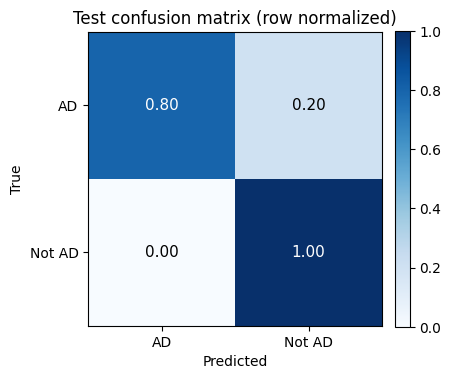

In [15]:
# =============================================================================
# TEST confusion matrix (row-normalized)
# =============================================================================
def plot_test_confmat_row_norm(labels, probs, threshold, out_png):
    preds = (probs >= threshold).astype(int)

    # y=0 -> AD, y=1 -> Not AD
    cm = confusion_matrix(labels, preds, labels=[0, 1]).astype(float)
    cm_norm = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)

    fig, ax = plt.subplots(figsize=(4.5, 4))
    im = ax.imshow(cm_norm, cmap="Blues")

    ax.set(
        xticks=[0, 1],
        yticks=[0, 1],
        xticklabels=["AD", "Not AD"],
        yticklabels=["AD", "Not AD"],
        xlabel="Predicted",
        ylabel="True",
        title="Test confusion matrix (row normalized)",
    )

    for i in range(2):
        for j in range(2):
            ax.text(
                j, i,
                f"{cm_norm[i, j]:.2f}",
                ha="center", va="center",
                color="white" if cm_norm[i, j] > 0.5 else "black",
                fontsize=11
            )

    ax.set_ylim(1.5, -0.5)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()

# save + plot
test_cm_png = os.path.join(OUT_DIR, "test_confusion_matrix.png")
plot_test_confmat_row_norm(test_labels, test_probs, best_t, test_cm_png)


In [23]:
!pip -q install shap


  0%|          | 0/15 [00:00<?, ?it/s]

SHAP values shape: (15, 6000, 1)
Squeezed SHAP values shape: (15, 6000)

Top 20 genes by mean |SHAP|:
 1. IL32|NONNEUR              mean|SHAP| = 0.003718
 2. AC107959.1|GLU            mean|SHAP| = 0.003260
 3. MT1F|NONNEUR              mean|SHAP| = 0.003257
 4. CPVL|NONNEUR              mean|SHAP| = 0.002850
 5. AC007749.2|GLU            mean|SHAP| = 0.002830
 6. LARP6|NONNEUR             mean|SHAP| = 0.002729
 7. ADAMTS18|NONNEUR          mean|SHAP| = 0.002634
 8. VIM|NONNEUR               mean|SHAP| = 0.002632
 9. LINC01088|NONNEUR         mean|SHAP| = 0.002575
10. AC098617.1|GABA           mean|SHAP| = 0.002559
11. CTXN1|NONNEUR             mean|SHAP| = 0.002552
12. PARD3|GLU                 mean|SHAP| = 0.002525
13. LINC02400|GLU             mean|SHAP| = 0.002290
14. AC064829.1|GABA           mean|SHAP| = 0.002216
15. AC006504.2|GLU            mean|SHAP| = 0.002126
16. QRICH2|GABA               mean|SHAP| = 0.002053
17. XRRA1|GLU                 mean|SHAP| = 0.002011
18. CHL1-AS2|N

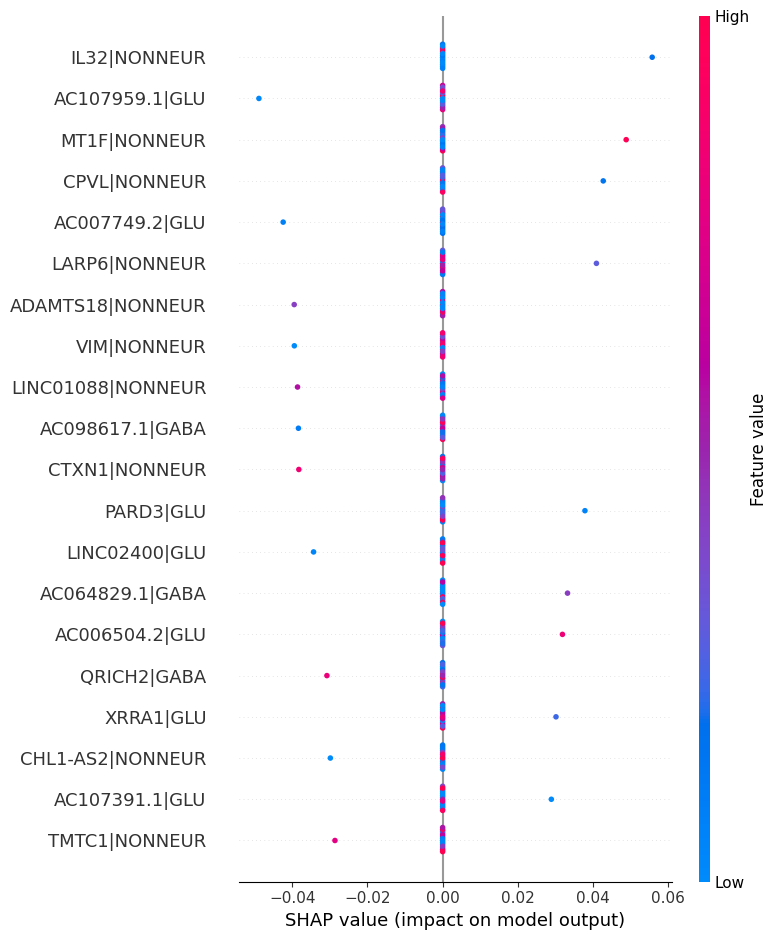

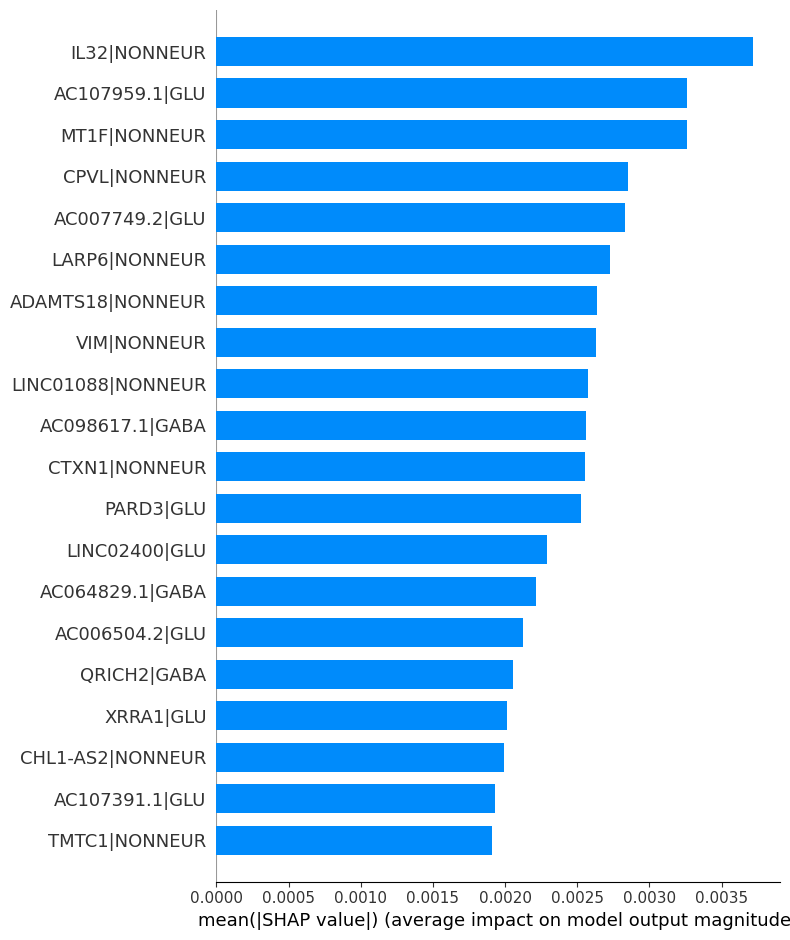

In [27]:
# =========================
# SHAP: Gene importance
# =========================
!pip -q install shap

import shap
import numpy as np
import pandas as pd
import torch

# -------------------------
# 1) Prepare model wrapper
# -------------------------
model.eval()

def model_forward(x_numpy):
    """SHAP expects numpy -> numpy"""
    x_t = torch.from_numpy(x_numpy).float().to(device)
    with torch.no_grad():
        logits = model(x_t)
        probs = torch.sigmoid(logits).cpu().numpy()
    return probs

# -------------------------
# 2) Background + eval sets
# -------------------------
# VERY IMPORTANT for stability with 6000 genes
rng = np.random.default_rng(0)

bg_idx   = rng.choice(len(X_train), size=min(20, len(X_train)), replace=False)
eval_idx = rng.choice(len(X_test),  size=min(15, len(X_test)),  replace=False)

X_bg   = X_train[bg_idx]
X_eval = X_test[eval_idx]

# -------------------------
# 3) Run SHAP
# -------------------------
explainer = shap.KernelExplainer(model_forward, X_bg)

shap_values = explainer.shap_values(
    X_eval,
    nsamples=300        # keep small → stable
)

shap_values = np.array(shap_values)

print("SHAP values shape:", shap_values.shape)

# squeeze singleton output dim if present
if shap_values.ndim == 3 and shap_values.shape[-1] == 1:
    shap_values = shap_values[..., 0]
    print("Squeezed SHAP values shape:", shap_values.shape)

# -------------------------
# 4) Aggregate importance
# -------------------------
mean_abs_shap = np.mean(np.abs(shap_values), axis=0).astype(float)

gene_names = np.array(adata.var_names, dtype=str)

top_n = 20
top_idx = np.argsort(mean_abs_shap)[::-1][:top_n]

print(f"\nTop {top_n} genes by mean |SHAP|:")
for rank, idx in enumerate(top_idx, 1):
    print(
        f"{rank:2d}. {gene_names[idx]:25s} "
        f"mean|SHAP| = {mean_abs_shap[idx]:.6f}"
    )

# Save table
imp_df = pd.DataFrame({
    "gene": gene_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

imp_df.to_csv(
    "/content/drive/MyDrive/Intro Genome Final project/shap_gene_importance.csv",
    index=False
)

print("\nSaved SHAP importance table.")

# -------------------------
# 5) SHAP plots
# -------------------------
shap.initjs()

# Dot plot
shap.summary_plot(
    shap_values,
    X_eval,
    feature_names=gene_names,
    max_display=20
)

# Bar plot
shap.summary_plot(
    shap_values,
    X_eval,
    feature_names=gene_names,
    plot_type="bar",
    max_display=20
)
